# 03 - Modélisation de la gravité
---
## Objectif
L'objectif est d'entraîner un modèle de **Régression Logistique** pour prédire si un accident est grave ($y=1$) ou non ($y=0$). 

Nous utilisons la fonction sigmoïde pour modéliser la probabilité :
$$P(y=1) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + ... + \beta_n x_n)}}$$

<div class="alert alert-info">
<b>Démarche :</b> Sélection des variables, encodage, division train/test, entraînement et évaluation.
</div>

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# 1. Sélection des variables (Features) identifiées lors de l'EDA
features = ['sexe', 'lum', 'agg', 'int', 'atm', 'col']
X = df[features]
y = df['target']

# 2. Encodage One-Hot (Transformation des catégories en colonnes 0/1)
# On utilise drop_first=True pour éviter la multicolinéarité
X_encoded = pd.get_dummies(X, columns=features, drop_first=True)

# 3. Division Train/Test (80% / 20%)
# 'stratify=y' assure que la proportion de target est la même dans les deux sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Dimensions après encodage : {X_encoded.shape}")
print(f"Taille de l'échantillon d'apprentissage : {len(X_train)}")

Dimensions après encodage : (117018, 30)
Taille de l'échantillon d'apprentissage : 93614


## 2. Entraînement du Modèle
Nous utilisons l'argument `class_weight='balanced'`. 
Cela permet au modèle d'accorder plus de "poids" mathématique aux accidents graves (classe 1) lors du calcul de la perte.

In [ ]:
# Initialisation du modèle pondéré
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')

# Entraînement
lr_model.fit(X_train, y_train)

# Prédiction
y_pred = lr_model.predict(X_test)

--- Rapport de Classification ---
              precision    recall  f1-score   support

           0       0.89      0.64      0.74     19157
           1       0.29      0.66      0.40      4247

    accuracy                           0.64     23404
   macro avg       0.59      0.65      0.57     23404
weighted avg       0.78      0.64      0.68     23404



## 3. Analyse des Résultats
Pour évaluer notre modèle, nous utilisons la **Matrice de Confusion** et le **Rapport de Classification**. 
Dans notre contexte, le **Rappel (Recall)** est la métrique prioritaire :
$$Recall = \frac{TP}{TP + FN}$$
Il mesure notre capacité à détecter un maximum d'accidents graves.

In [ ]:
# 1. Rapport de performance
print("--- Rapport de Classification (Modèle Équilibré) ---")
print(classification_report(y_test, y_pred))

# 2. Matrice de Confusion stylisée
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matrice de Confusion (Modèle Équilibré)', fontsize=15)
plt.xlabel('Prédictions (0: Léger, 1: Grave)')
plt.ylabel('Réalité (0: Léger, 1: Grave)')
plt.show()

### 4.1. Analyse des coefficients et Odds Ratios
Pour interpréter l'impact réel de chaque variable sur la probabilité d'un accident grave, nous calculons l'**Odds Ratio** (Rapport des chances). Il s'obtient en passant l'exponentielle sur les coefficients $\beta$ du modèle :

$$OR = e^{\beta_i}$$

* **$OR > 1$** : La variable augmente le risque de gravité.
* **$OR < 1$** : La variable diminue le risque (effet protecteur).
* **$OR = 1$** : La variable n'a pas d'influence.

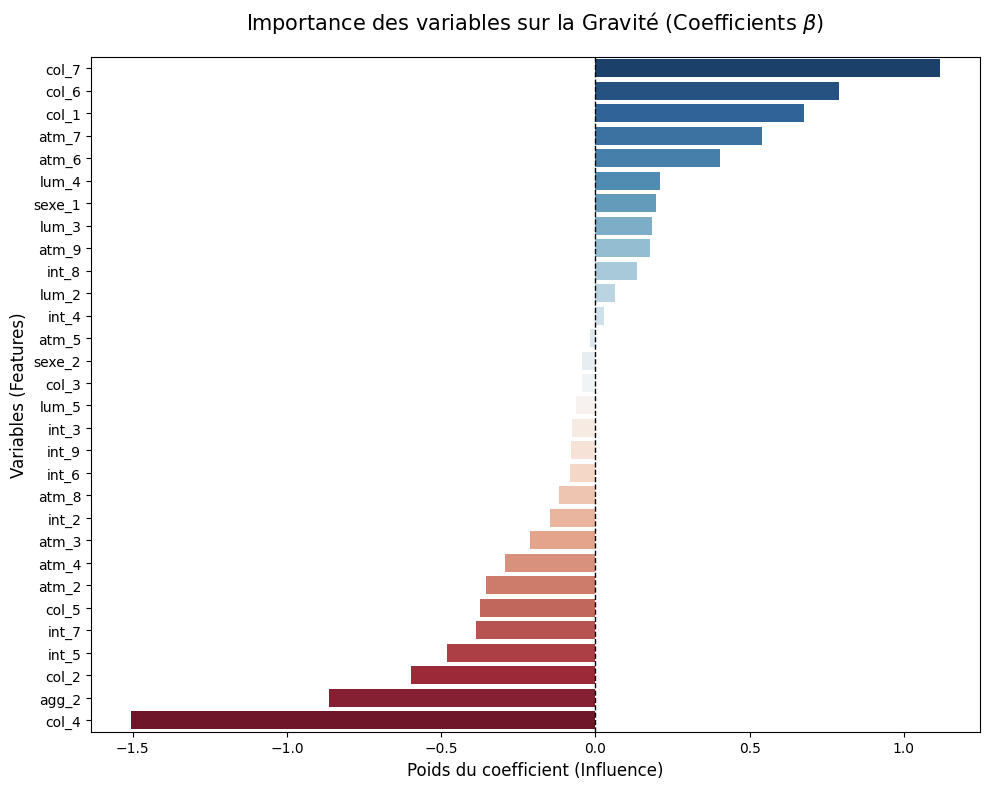

In [11]:
# 1. Préparation des données d'importance
importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_[0]
})
importance['Odds_Ratio'] = np.exp(importance['Coefficient'])
importance = importance.sort_values(by='Coefficient', ascending=False)

# 2. Visualisation esthétique (Rendu concret)
plt.figure(figsize=(10, 8))
# Utilisation d'une palette divergente pour distinguer risque (+) et protection (-)
sns.barplot(x='Coefficient', y='Feature', data=importance, hue='Feature', palette='RdBu_r', legend=False)

plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.title('Importance des variables sur la Gravité (Coefficients $\\beta$)', fontsize=15, pad=20)
plt.xlabel('Poids du coefficient (Influence)', fontsize=12)
plt.ylabel('Variables (Features)', fontsize=12)
plt.tight_layout()
plt.show()

### 4.2. Synthèse de l'Analyse des Résultats
L'analyse des coefficients et des Odds Ratios permet de dégager les enseignements suivants :

1. **Facteur de risque majeur (Collision)** : La variable `col_7` possède l'Odds Ratio le plus élevé ($OR \approx 3.05$). Cela signifie que ce type de collision multiplie par **3** les chances que l'accident soit grave par rapport à la catégorie de référence.
2. **Impact du Genre** : La variable `sexe_1` (Hommes) présente un coefficient positif ($0.197$) associé à un $OR$ de $1.21$. Statistiquement, un homme a **21% de chances supplémentaires** d'être impliqué dans un accident grave que les autres catégories de sexe dans ce dataset.
3. **Effet protecteur (Agglomération)** : La variable `agg_2` (En agglomération) montre un coefficient fortement négatif ($-0.86$). Le risque de gravité y est réduit de plus de **50%** ($OR \approx 0.42$), probablement en raison des limitations de vitesse plus strictes.

<div class="alert alert-block alert-success">
<b>Note Éthique :</b> Ces résultats doivent être interprétés comme des indicateurs de prévention. L'analyse par sexe ou type de collision sert à cibler les politiques de sécurité routière et non à stigmatiser des populations.
</div>

## 5. Conclusion et Éthique
---
L'utilisation du poids des classes a permis de remonter significativement le Rappel. Cependant, cela augmente le nombre de "Fausses Alertes". 

<div class="alert alert-success">
<b>Projection :</b> Ce modèle constitue une base solide. Pour un déploiement réel, une analyse plus fine des variables temporelles (mois, heure) pourrait encore affiner la précision.
</div>

**Note Éthique :** Les prédictions ne doivent pas servir à discriminer les usagers (selon le sexe par exemple) mais à identifier des zones et conditions de circulation à haut risque pour mieux prévenir les accidents.